In [ ]:
import numpy as np
import math 
import queue
import os
import neat
import visualize
import random
import matplotlib.pyplot as plt
import pickle

%load_ext autoreload
%autoreload 2

import GameManager
from GameManager import *

import Neat_AI
from Neat_AI import *

import AI_modules
from AI_modules import *

import my_reporters
from my_reporters import *

In [2]:
local_dir = os.path.abspath('')
config_path = os.path.join(local_dir, 'config-feedforward')

In [3]:
from multiprocessing import Pool
from timeit import default_timer as timer
import defs

#Create sizes for 3 arrays. 
sizes = [5 * 10**7 for i in range(0,3)] #Size of each array is 10 here.
#Applying the function sequentially
tic = timer()
[defs.createandsort(size) for size in sizes]
tac = timer()
print("time for sequential sorting: ", tac-tic)
#Using multiprocessing
#if __name__ == "__main__":

pool = Pool(processes=3)
tic = timer()
pool.map(defs.createandsort,sizes)
tac = timer()
print("time for parallel sorting: ",tac-tic)

time for sequential sorting:  14.806821499999998
time for parallel sorting:  5.260431499999999


In [4]:
dimensions = (8,8)
manager = map_manager(dimensions)
#print(manager)

manager.setup_layouts_rand(layout_n=10, unit_count=5)
for i in range(len(manager.map_layouts)):
    manager.apply_map_layout(i)
    #print(manager)
    

In [ ]:
dimensions = (8,8)
units_per_side = 5
manager = map_manager(dimensions)

# for i in range(games_run):
#also resets map
manager.setup_rand(units_per_side)
print(manager)

while (manager.game_joever() == -1 and manager.turn_count < 8): #Turn Count limit may have to be modified
    for unit in manager.Teams[manager.curr_team].live_units:
        win_move = (0, 0)
        if manager.curr_team == 0:
            win_move = neat_ai(manager, unit, win_net)
        elif manager.curr_team == 1:
            win_move = script_ai(manager, unit)\
            #win_move = neat_ai(manager, unit, win_net)
        manager.move_unit(unit, win_move)
        print(manager)
    manager.Turn()

In [29]:
dimensions = (8,8)
units_per_side = 5
manager = map_manager(dimensions)

# for i in range(games_run):
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)
script_performance(manager, win_net, config)

In [20]:
10%9

1

<class 'my_reporters.genome_reporter'>

 ****** Running generation 0 ****** 

Returned fitness: [0.0, 0.0, 0.0, 0.0, 0.0]
jobs done!
Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (2, 61) - species 1 - id 1
generation: 0
Average adjusted fitness: 0.000
Mean genetic distance 2.082, standard deviation 1.104
Population of 6 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0     2      0.0    0.000     0
     2    0     2      0.0    0.000     0
     3    0     2      0.0    0.000     0
Total extinctions: 0
Generation time: 3.304 sec

 ****** Running generation 1 ****** 

Returned fitness: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
jobs done!
Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (2, 61) - species 1 - id 1
generation: 1
Average adjusted fitness: 0.000
Mean genetic distance 2.082, standard deviation 1.104
Population of 6 members in 3 species:
   ID   age  s

Returned fitness: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
jobs done!
Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (2, 61) - species 2 - id 2
generation: 3
Average adjusted fitness: 0.000
Mean genetic distance 2.082, standard deviation 1.104
Population of 6 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   13     2      0.0    0.000    10
     2   13     2      0.0    0.000    13
     3   13     2      0.0    0.000    13
Total extinctions: 0
Generation time: 1.827 sec (2.723 average)

 ****** Running generation 14 ****** 

Returned fitness: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
jobs done!
Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (2, 61) - species 2 - id 2
generation: 4
Average adjusted fitness: 0.000
Mean genetic distance 2.082, standard deviation 1.104
Population of 6 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  

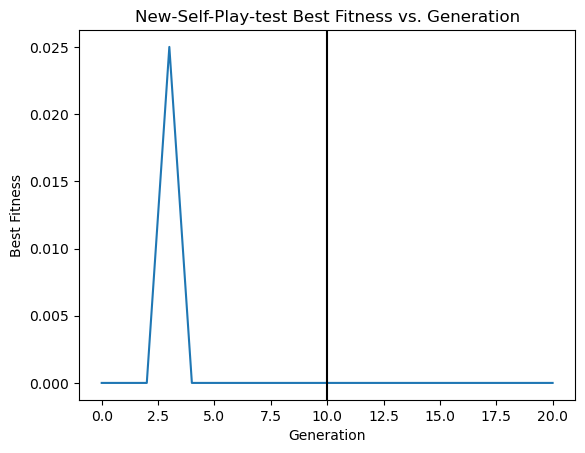

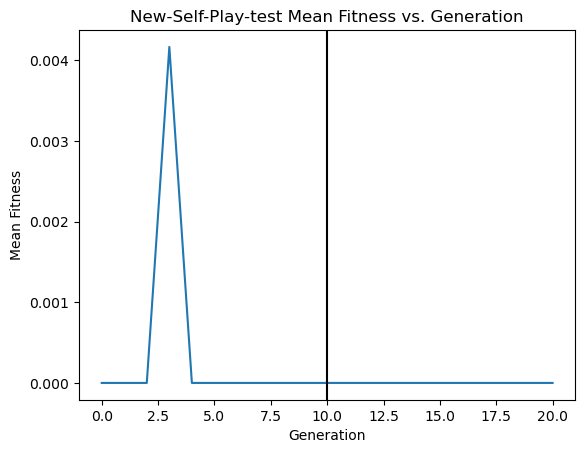

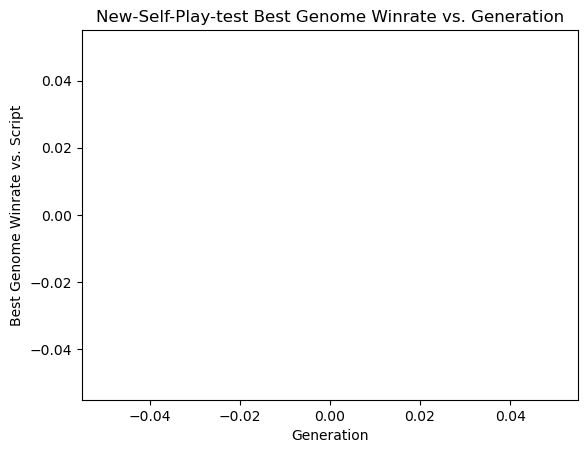

Average adjusted fitness: 0.000
Mean genetic distance 2.082, standard deviation 1.104
Population of 6 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   20     2      0.0    0.000    17
     2   20     2      0.0    0.000    20
     3   20     2      0.0    0.000    20
Total extinctions: 0
Generation time: 3.322 sec (1.984 average)

 ****** Running generation 21 ****** 

Returned fitness: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
jobs done!
Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (2, 61) - species 2 - id 2
generation: 11
Average adjusted fitness: 0.000
Mean genetic distance 2.082, standard deviation 1.104
Population of 6 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   21     2      0.0    0.000    18
     2   21     2      0.0    0.000    21
     3   21     2      0.0    0.000    21
Total extinctions: 0
Generation time: 3.503

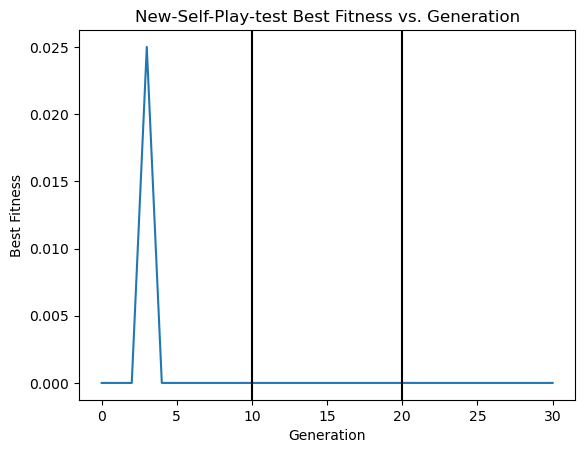

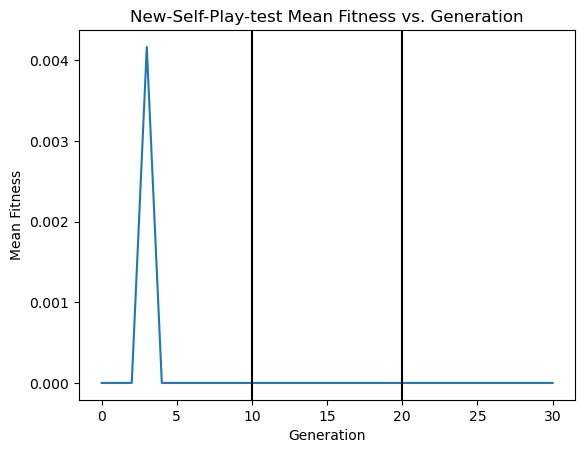

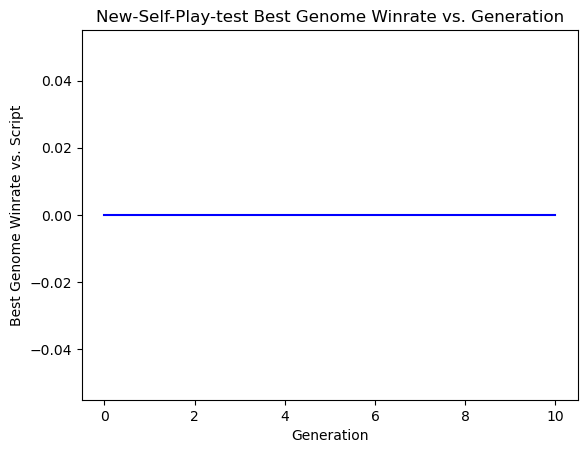

Average adjusted fitness: 0.000
Mean genetic distance 2.082, standard deviation 1.104
Population of 6 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   30     2      0.0    0.000    27
     2   30     2      0.0    0.000    30
     3   30     2      0.0    0.000    30
Total extinctions: 0
Generation time: 6.674 sec (3.901 average)

 ****** Running generation 31 ****** 

Returned fitness: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
jobs done!
Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (2, 61) - species 2 - id 2
generation: 21
Average adjusted fitness: 0.000
Mean genetic distance 2.082, standard deviation 1.104
Population of 6 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   31     2      0.0    0.000    28
     2   31     2      0.0    0.000    31
     3   31     2      0.0    0.000    31
Total extinctions: 0
Generation time: 3.493

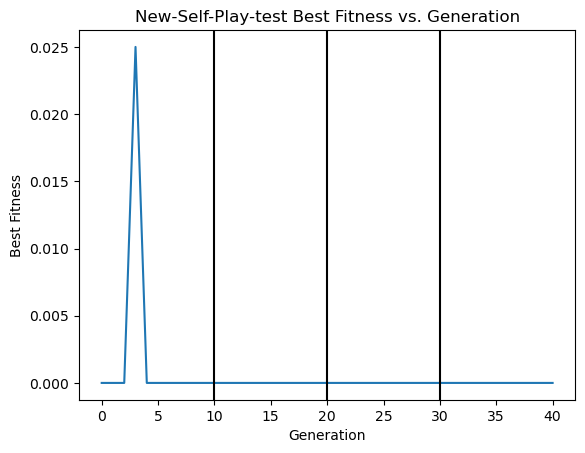

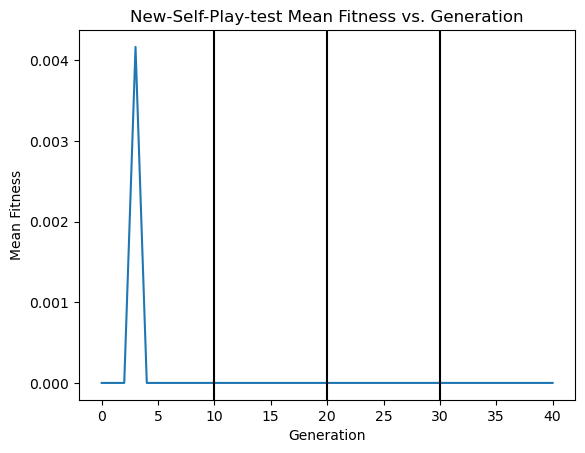

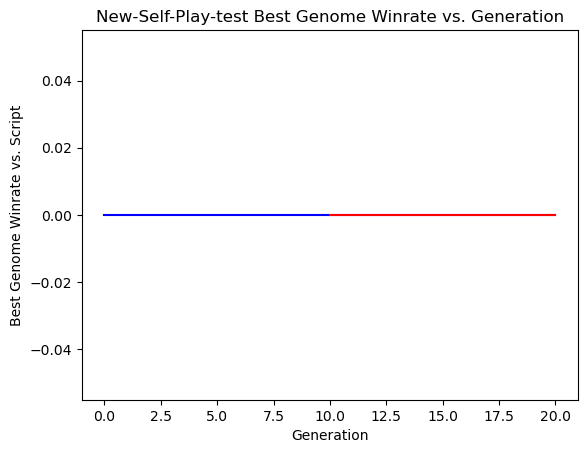

Average adjusted fitness: 0.000
Mean genetic distance 2.082, standard deviation 1.104
Population of 6 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   40     2      0.0    0.000    37
     2   40     2      0.0    0.000    40
     3   40     2      0.0    0.000    40
Total extinctions: 0
Generation time: 8.116 sec (3.917 average)

 ****** Running generation 41 ****** 

Returned fitness: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
jobs done!
Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (2, 61) - species 2 - id 2
generation: 31
Average adjusted fitness: 0.000
Mean genetic distance 2.082, standard deviation 1.104
Population of 6 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   41     2      0.0    0.000    38
     2   41     2      0.0    0.000    41
     3   41     2      0.0    0.000    41
Total extinctions: 0
Generation time: 3.101

Traceback (most recent call last):
  File "C:\Users\kevin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\kevin\AppData\Local\Temp\ipykernel_1252\732062750.py", line 2, in <module>
    win_net, win_genome, stats = Neat_AI.run(config_path, "New Self-Play test")
  File "C:\_Kevin\UT-Stuff\_Summer2023\CS370\kriek-cs370\Neat_AI.py", line 183, in run
  File "C:\Users\kevin\anaconda3\lib\site-packages\neat\population.py", line 89, in run
    fitness_function(list(iteritems(self.population)), self.config)
  File "C:\_Kevin\UT-Stuff\_Summer2023\CS370\kriek-cs370\Neat_AI.py", line 106, in eval_genomes
    run_name = run_name.replace(' ', '-')
  File "C:\Users\kevin\anaconda3\lib\multiprocessing\pool.py", line 372, in starmap
    return self._map_async(func, iterable, starmapstar, chunksize).get()
  File "C:\Users\kevin\anaconda3\lib\multiprocessing\pool.py", line 765, in get
    self.wai

In [24]:
random.seed(4123) #This is to set the random generated board starting positions
win_net, win_genome, stats = Neat_AI.run(config_path, "New Self-Play test")

In [234]:
win_net1 = win_net
stats1 = stats

In [267]:
#Restore a checkpoint to resume Run
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)
a
p = neat.checkpoint.Checkpointer.restore_checkpoint("./checkpoints/Global-Position-Eval-Func_vsScript_difference/neat-checkpoint-29")
winner = p.run(eval_genomes, 1)
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

Mean genetic distance 1.323, standard deviation 0.442


In [172]:
#Restoring a best network for testing
net = load_net("./best/Relative-Position-Eval-Func-config", "./best/Relative-Position-Eval-Func-genome")
print(net)